<a href="https://colab.research.google.com/github/tram-tr/predicting-molecular-properties/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# need authorization code to mount drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [4]:
!pip install kaggle
!kaggle competitions download -c champs-scalar-coupling
!pip install ase # visualize molecule

 99% 374M/377M [00:18<00:00, 29.8MB/s]
100% 377M/377M [00:18<00:00, 21.2MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00


In [5]:
!unzip /content/champs-scalar-coupling.zip

Streaming output truncated to the last 5000 lines.
  inflating: structures/dsgdb9nsd_128302.xyz  
  inflating: structures/dsgdb9nsd_128303.xyz  
  inflating: structures/dsgdb9nsd_128304.xyz  
  inflating: structures/dsgdb9nsd_128305.xyz  
  inflating: structures/dsgdb9nsd_128306.xyz  
  inflating: structures/dsgdb9nsd_128308.xyz  
  inflating: structures/dsgdb9nsd_128309.xyz  
  inflating: structures/dsgdb9nsd_128310.xyz  
  inflating: structures/dsgdb9nsd_128311.xyz  
  inflating: structures/dsgdb9nsd_128312.xyz  
  inflating: structures/dsgdb9nsd_128313.xyz  
  inflating: structures/dsgdb9nsd_128314.xyz  
  inflating: structures/dsgdb9nsd_128315.xyz  
  inflating: structures/dsgdb9nsd_128316.xyz  
  inflating: structures/dsgdb9nsd_128317.xyz  
  inflating: structures/dsgdb9nsd_128318.xyz  
  inflating: structures/dsgdb9nsd_128319.xyz  
  inflating: structures/dsgdb9nsd_128320.xyz  
  inflating: structures/dsgdb9nsd_128321.xyz  
  inflating: structures/dsgdb9nsd_128322.xyz  
  inflati

In [7]:
!pip install openbabel-wheel

In [8]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.0 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
import ase
import ase.visualize
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from collections import Counter, namedtuple
import scipy.sparse as sparse
from openbabel import pybel
from openbabel import openbabel
from scipy.sparse import csr_matrix
from typing import List
from tqdm.auto import tqdm

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
structures = pd.read_csv('structures.csv')

# **Data Exploration**



In [ ]:
def visualize(mol_name):
  struct = structures[structures['molecule_name'] == mol_name]
  xcart = struct.iloc[:, 3:].values
  symbols = struct.iloc[:, 2].values
  system = ase.Atoms(positions=xcart, symbols=symbols)
  print(symbols)
  print(f'molecule name: {mol_name}')
  return ase.visualize.view(system, viewer='x3d')

In [ ]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [ ]:
visualize('dsgdb9nsd_000001')

['C' 'H' 'H' 'H' 'H']
molecule name: dsgdb9nsd_000001


nummber of unique molecules in train 85012
nummber of unique molecules in test 45777


<Axes: title={'center': 'test.csv'}, xlabel='frequency of molecular occurrence', ylabel='counts'>

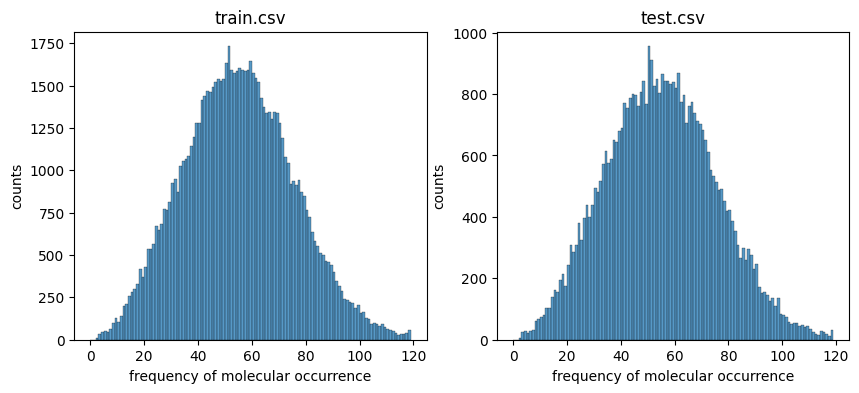

In [ ]:
print(f'nummber of unique molecules in train {len(train.molecule_name.unique())}')
print(f'nummber of unique molecules in test {len(test.molecule_name.unique())}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.ylabel('counts')
plt.xlabel('frequency of molecular occurrence')
plt.title('train.csv')
sns.histplot(train.molecule_name.value_counts(), kde=False, bins=list(range(120)))

plt.subplot(1, 2, 2)
plt.ylabel('counts')
plt.xlabel('frequency of molecular occurrence')
plt.title('test.csv')
sns.histplot(test.molecule_name.value_counts(), kde=False, bins=list(range(120)))

number of J coupling types in train: type
3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: count, dtype: int64
number of J coupling types in test: type
3JHC    811351
2JHC    613087
1JHC    380968
3JHH    317582
2JHH    203201
3JHN     90459
2JHN     64647
1JHN     23895
Name: count, dtype: int64


(0.0, 1000000.0)

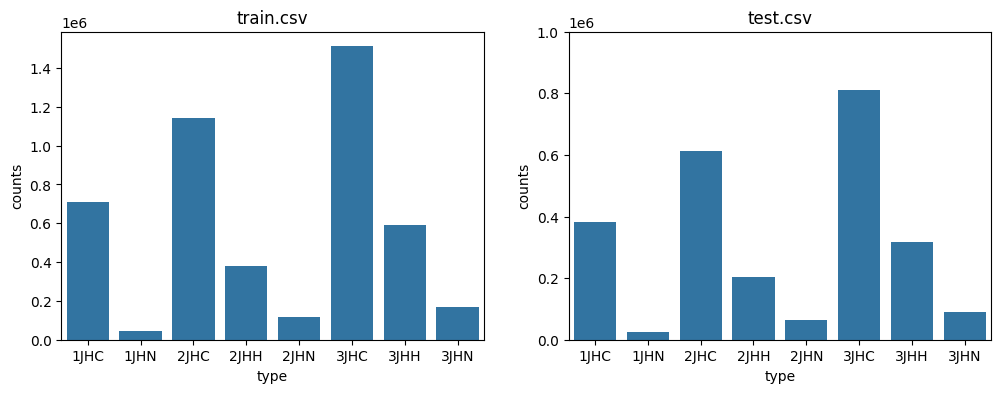

In [ ]:
print(f"number of J coupling types in train: {train['type'].value_counts()}")
print(f"number of J coupling types in test: {test['type'].value_counts()}")

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=train['type'], ax=axes[0], order=sorted(train['type'].unique()))
axes[0].set_title('train.csv')
axes[0].set_xlabel('type')
axes[0].set_ylabel('counts')

sns.countplot(x=test['type'], ax=axes[1], order=sorted(test['type'].unique()))
axes[1].set_title('test.csv')
axes[1].set_xlabel('type')
axes[1].set_ylabel('counts')
axes[1].set_ylim(0, 1e6)

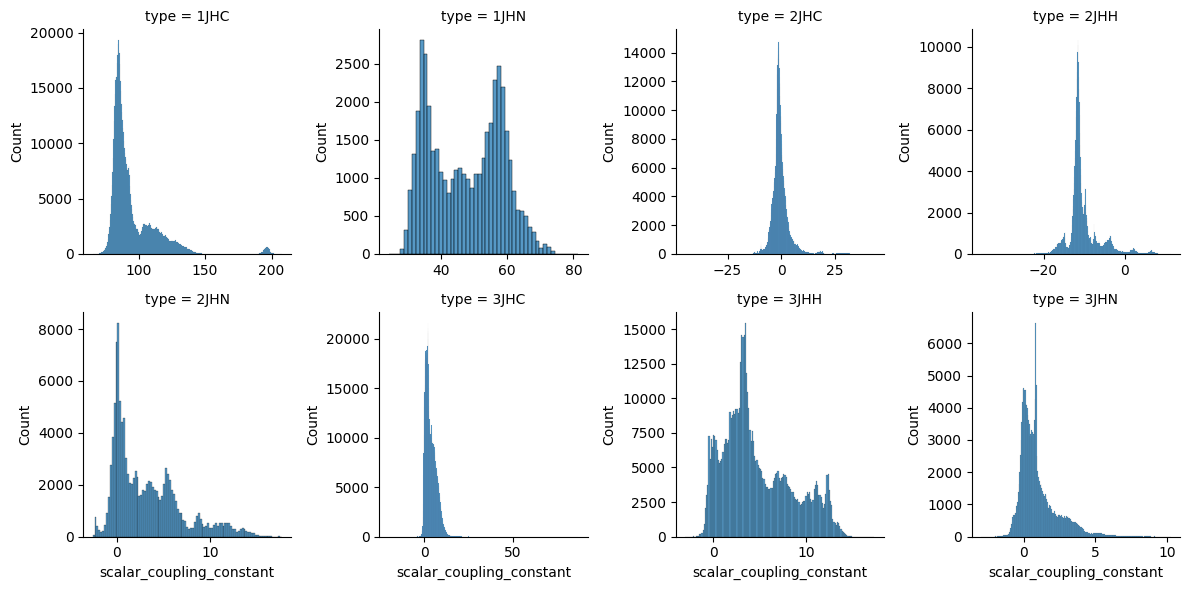

In [ ]:
g = sns.FacetGrid(train, col="type",
                  col_order=sorted(train['type'].unique()),
                  sharex=False, sharey=False, col_wrap=4)
g.map(sns.histplot, "scalar_coupling_constant")

Text(0.5, 0, 'number of atoms')

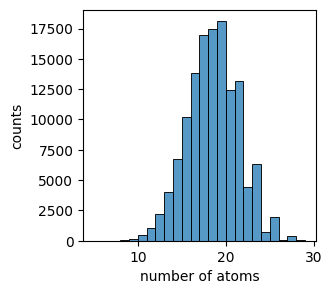

In [ ]:
structure_counts = structures.groupby(['molecule_name', 'atom']).size().unstack(fill_value=0)
structure_counts['total_atoms'] = structure_counts.sum(axis=1)

structure_counts.columns.name = None
structure_counts.index.name = None

structure_counts.rename(columns={'C': 'n_C', 'H': 'n_H', 'N': 'n_N', 'O': 'n_O', 'F': 'n_F'}, inplace=True)

plt.figure(figsize=(3, 3))
sns.histplot(structure_counts['total_atoms'], kde=False, bins=range(5, 30))
plt.ylabel('counts')
plt.xlabel('number of atoms')


In [ ]:
structure_counts.describe()

,n_C,n_F,n_H,n_N,n_O,total_atoms
count,130789.000000,130789.000000,130789.000000,130789.000000,130789.000000,130789.000000
mean,6.359931,0.022907,9.239967,1.012180,1.400745,18.035729
std,1.228364,0.214674,2.813650,1.074138,0.883497,2.938573
min,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
25%,6.000000,0.000000,7.000000,0.000000,1.000000,16.000000
50%,6.000000,0.000000,9.000000,1.000000,1.000000,18.000000
75%,7.000000,0.000000,11.000000,2.000000,2.000000,20.000000
max,9.000000,6.000000,20.000000,7.000000,5.000000,29.000000


# **Feature Engineering**

In [ ]:
'''# number of bonds in the J type coupling
train['type_bond'] = train['type'].map(lambda x: int(x[0]))
# atoms in the J type coupling
train['type_atom_0'] = train['type'].map(lambda x: x[-2])
train['type_atom_1'] = train['type'].map(lambda x: x[-1])
train.head()'''

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,type_atom_0,type_atom_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,H,C
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,H,H
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,H,H
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,H,H
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,H,C


In [ ]:
def process_xyz(filepath):
    """
    reads a file path and returns RDKit Mol Object, 3D Distance Matrix, and Adjacency Matrix among other properties.

    args:
        filepath (str): Path to the .xyz file containing the molecular structure.

    returns:
        tuple: Contains various molecular properties and matrices.
    """

    # load molecule using Pybel
    pb_mol = next(pybel.readfile("xyz", filepath))

    # extract atomic properties and initialize RDKit molecule and conformer
    num_atoms = len(pb_mol.atoms)
    rw_mol = rdkit.Chem.RWMol()
    conf = rdkit.Chem.Conformer(num_atoms)
    atom_counts = Counter()
    hybrid_orbitals = []
    atoms = []
    partial_charges = []
    atom_coordinates = []
    atom_spins = []
    atom_valences = []
    atom_formal_charges = []

    for i, atom in enumerate(pb_mol.atoms):
        rw_mol.AddAtom(rdkit.Chem.Atom(atom.atomicnum))
        conf.SetAtomPosition(i, atom.coords)
        atom_coordinates.append(np.array(atom.coords))
        atom_counts += Counter([atom.type])
        atoms.append(atom.type)
        hybrid_orbitals.append(int(atom.hyb))
        partial_charges.append(atom.partialcharge)
        atom_spins.append(int(atom.spin))
        atom_valences.append(int(atom.degree))
        atom_formal_charges.append(atom.formalcharge)

    # finalize RDKit Mol Object
    mol = rw_mol.GetMol()
    mol.AddConformer(conf)

    # compute 3D distance matrix
    dist_matrix = np.array(rdkit.Chem.Get3DDistanceMatrix(mol))

    # create adjacency Matrix
    adj_matrix = np.zeros((num_atoms, num_atoms), dtype=int)
    for bond in openbabel.OBMolBondIter(pb_mol.OBMol):
        i, j = bond.GetBeginAtomIdx() - 1, bond.GetEndAtomIdx() - 1
        bond_order = bond.GetBondOrder()
        adj_matrix[i][j] = adj_matrix[j][i] = bond_order

    return (dist_matrix, adj_matrix, atoms, hybrid_orbitals, pb_mol.OBMol.NumBonds(),
            partial_charges, atom_coordinates, atom_spins, atom_valences, atom_formal_charges)


In [ ]:
def vector_angle(v1, v2):
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return np.nan

    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    return np.arccos(np.clip(cos_theta, -1.0, 1.0)) * (180.0 / np.pi)

def bond_angle(atom1, atom2, atom3):
    vect12 = atom1 - atom2
    vect32 = atom3 - atom2
    return vector_angle(vect32, vect12)

def dihedral_angle(atom1, atom2, atom3, atom4):
    """
    returns the dihedral angle between atoms 1 and 4
    given the x, y, z coordinates of all four atoms
    """

    vec_12 = atom1 - atom2
    vec_23 = atom2 - atom3
    vec_34 = atom3 - atom4

    # calculate the normal vector for the plane that contains bonds 2-3 and 3-4
    norm = np.cross(vec_23, vec_34)

    # subtract 90 deg to get the angle between the plane and vec_12
    return vector_angle(vec_12, norm) - 90

In [ ]:
def get_features(dist_mat, atoms, atom_index):
    features = {}
    atom_distances = dist_mat[atom_index, :]

    nonzero_distances = atom_distances[atom_distances > 0]
    features['min'] = nonzero_distances.min() if nonzero_distances.size > 0 else -1
    features['mean'] = nonzero_distances.mean() if nonzero_distances.size > 0 else -1
    features['max'] = nonzero_distances.max() if nonzero_distances.size > 0 else -1

    for atom_type in ['C', 'O', 'N', 'F']:
        type_mask = np.array([1 if atom[0] == atom_type else 0 for atom in atoms])
        type_distances = atom_distances * type_mask
        filtered_distances = type_distances[type_distances > 0]

        if filtered_distances.size > 0:
            features[f'{atom_type}min'] = filtered_distances.min()
            features[f'{atom_type}mean'] = filtered_distances.mean()
            features[f'{atom_type}max'] = filtered_distances.max()
        else:
            features[f'{atom_type}min'] = -1
            features[f'{atom_type}mean'] = -1
            features[f'{atom_type}max'] = -1

    return features

In [ ]:
def dfs_util(atom_index_0, atom_index_1, max_length, adj_matrix, current_path, all_paths):
    """
    Utility function for depth-first search to find all paths between two atoms.

    Args:
        atom_index_0 (int): Starting atom index.
        atom_index_1 (int): Ending atom index.
        max_length (int): Maximum length of the path.
        adj_matrix (csr_matrix): Sparse adjacency matrix representing the molecule.
        current_path (List[int]): Currently explored path.
        all_paths (List[List[int]]): All paths found from atom_index_0 to atom_index_1.
    """
    # Base case: if max length reached or the end atom is found
    if len(current_path) > max_length or (len(current_path) > 1 and current_path[-1] == atom_index_1):
        if current_path[-1] == atom_index_1:
            all_paths.append(list(current_path))  # Append a copy of the current path
        return

    for neighbor in adj_matrix[current_path[-1]].indices:
        if neighbor not in current_path:  # Avoid cycles
            current_path.append(neighbor)
            dfs_util(atom_index_0, atom_index_1, max_length, adj_matrix, current_path, all_paths)
            current_path.pop()  # Backtrack

def find_paths(adj_matrix, atom_index_0, atom_index_1, num_bonds):
    """
    Finds all paths between two atoms within a molecule using DFS.

    Args:
        atom_index_0 (int): Index of the starting atom.
        atom_index_1 (int): Index of the ending atom.
        num_bonds (int): Maximum number of bonds to be considered in the path.
        adj_matrix (csr_matrix): Sparse adjacency matrix of the molecule.

    Returns:
        List[List[int]]: A list of all paths found, with each path represented as a list of atom indices.
    """
    all_paths = []
    dfs_util(atom_index_0, atom_index_1, num_bonds + 1, adj_matrix, [atom_index_0], all_paths)
    return all_paths


In [ ]:
def extend_df(df):
  features = {
    'n_bonds': [], # number of bonds in the molecule
    'min_d': [], # min distance between any two atoms in the molecule
    'mean_d': [], # mean distance -
    'max_d': [], # max distance -

    'space_dist': [], # spatial distance between atom_index_0 and target_atom
    'bond_dist': [], # bond distance for bonded atoms, else -1
    'bond_1': [], # bond order between atom_index_0 and its neighbor
    'bond_2': [], # bond order between a neighbor of atom_index_0 and another atom along the path to target_atom
    'bond_3': [], # bond order for the third bond in the path from atom_index_0 to target_atom

    'atom_0_pc': [], # partial charge of atom_index_0
    'target_atom_pc': [], # partial charge of target_atom

    'atom_0_fc': [], # formal charge of atom_index_0
    'target_atom_fc': [], # partial charge of target_atom

    'atom_0_val': [], # valence elections
    'target_atom_val': [],

    'atom_0_sm': [], # spin multiplicity
    'target_atom_sm': [],

    'atom_0_symbol': [], # chemical symbol
    'atom_2_symbol': [],
    'atom_3_symbol': [],
    'target_atom_symbol': [],

    'atom_0_hyb': [], # hybridization
    'atom_2_hyb': [],
    'atom_3_hyb': [],
    'target_atom_hyb': [],

    'path_count': [], # number of paths between atom_0 and target_atom
    'bond_angle': [], # bond angle at the second bond in the path from atom_index_0 to target_atom
    'dihedral_angle': [], # dihedral angle involving the third bond in the path from atom_index_0 to target_atom

    # distance features based on specific atom types
    # for atom_index_0
    'atom_0_min': [],
    'atom_0_mean': [],
    'atom_0_max': [],
    'atom_0_Cmin': [],
    'atom_0_Cmean': [],
    'atom_0_Cmax': [],
    'atom_0_Omin': [],
    'atom_0_Omean': [],
    'atom_0_Omax': [],
    'atom_0_Nmin': [],
    'atom_0_Nmean': [],
    'atom_0_Nmax': [],
    'atom_0_Fmin': [],
    'atom_0_Fmean': [],
    'atom_0_Fmax': [],

    # for target_atom
    'target_atom_min': [],
    'target_atom_mean': [],
    'target_atom_max': [],
    'target_atom_Cmin': [],
    'target_atom_Cmean': [],
    'target_atom_Cmax': [],
    'target_atom_Omin': [],
    'target_atom_Omean': [],
    'target_atom_Omax': [],
    'target_atom_Nmin': [],
    'target_atom_Nmean': [],
    'target_atom_Nmax': [],
    'target_atom_Fmin': [],
    'target_atom_Fmean': [],
    'target_atom_Fmax': [],
  }

  df['type_bond'] = df['type'].map(lambda x: int(x[0])) # number of bonds in the J type coupling
  df['target_atom'] = df['type'].map(lambda x: x[-1]) # ending atom in the J type coupling

  loaded_name = ''
  atom_dist_dict = {}

  for row in tqdm(df.itertuples(index=False)):
    i, j, mol_name = row.atom_index_0, row.atom_index_1, row.molecule_name
    n_bonds = row.type_bond

    if loaded_name != mol_name:
      loaded_name = mol_name
      filepath = f'structures/{mol_name}.xyz'
      dist_mat, adj_mat, atoms, hyb_orb, bond_count, pc_list, atom_coord, atom_spins, atom_val, atom_fc = process_xyz(filepath)
      sparse_adj_mat = sparse.csr_matrix(adj_mat)

      for key in ['n_bonds', 'min_d', 'mean_d', 'max_d']:
          features[key].append({'n_bonds': bond_count, 'min_d': np.min(dist_mat[np.nonzero(dist_mat)]),
                                'mean_d': np.mean(dist_mat[np.nonzero(dist_mat)]), 'max_d': np.max(dist_mat)}[key])
    else:
      for key in ['n_bonds', 'min_d', 'mean_d', 'max_d']:
          features[key].append(features[key][-1])

    features['space_dist'].append(dist_mat[i][j])
    features['atom_0_symbol'].append(atoms[i])
    features['target_atom_symbol'].append(atoms[j])
    features['atom_0_pc'].append(pc_list[i])
    features['target_atom_pc'].append(pc_list[j])

    features['atom_0_fc'].append(atom_fc[i])
    features['target_atom_fc'].append(atom_fc[j])
    features['atom_0_val'].append(atom_val[i])
    features['target_atom_val'].append(atom_val[j])
    features['atom_0_sm'].append(atom_spins[i])
    features['target_atom_sm'].append(atom_spins[j])
    features['atom_0_hyb'].append(hyb_orb[i])
    features['target_atom_hyb'].append(hyb_orb[j])

    paths = []
    if n_bonds > 1:
      paths = find_paths(sparse_adj_mat, i, j, n_bonds)
      features['path_count'].append(len(paths))

      if len(paths) > 0 and n_bonds >= 2:
        path = paths[0]
        if n_bonds == 2:
          features['bond_dist'].append(dist_mat[path[0]][path[1]] + dist_mat[path[1]][path[2]])
          features['bond_1'].append(adj_mat[path[0]][path[1]])
          features['bond_2'].append(adj_mat[path[1]][path[2]])
          features['bond_3'].append(-1)
          features['atom_2_symbol'].append(atoms[path[1]])
          features['atom_3_symbol'].append('')
          features['atom_2_hyb'].append(hyb_orb[path[1]])
          features['atom_3_hyb'].append(-1)

        if n_bonds > 2:
          features['bond_dist'].append(dist_mat[path[0]][path[1]] + dist_mat[path[1]][path[2]] + dist_mat[path[2]][path[3]])
          features['bond_1'].append(adj_mat[path[0]][path[1]])
          features['bond_2'].append(adj_mat[path[1]][path[2]])
          features['bond_3'].append(adj_mat[path[2]][path[3]])
          features['atom_2_symbol'].append(atoms[path[1]])
          features['atom_3_symbol'].append(atoms[path[2]])
          features['atom_2_hyb'].append(hyb_orb[path[1]])
          features['atom_3_hyb'].append(hyb_orb[path[2]])

        features['bond_angle'].append(bond_angle(atom_coord[0], atom_coord[1], atom_coord[2]) if n_bonds == 2 else -1)
        features['dihedral_angle'].append(dihedral_angle(atom_coord[0], atom_coord[1], atom_coord[2], atom_coord[3]) if n_bonds > 2 else -1)

    else:
      if n_bonds == 1:
        features['bond_dist'].append(dist_mat[i][j])
        features['bond_1'].append(adj_mat[i][j])
        features['bond_2'].append(-1)
        features['bond_3'].append(-1)
        features['atom_2_symbol'].append('')
        features['atom_3_symbol'].append('')
        features['atom_2_hyb'].append(-1)
        features['atom_3_hyb'].append(-1)

      features['path_count'].append(1)
      features['bond_angle'].append(-1)
      features['dihedral_angle'].append(-1)

    atom_0_features = get_features(dist_mat, atoms, i)
    target_atom_features = get_features(dist_mat, atoms, j)


    for feature_name in ['min', 'mean', 'max', 'Cmin', 'Cmean', 'Cmax', 'Omin', 'Omean', 'Omax', 'Nmin', 'Nmean', 'Nmax', 'Fmin', 'Fmean', 'Fmax']:
      features[f'atom_0_{feature_name}'].append(atom_0_features[feature_name])
      features[f'target_atom_{feature_name}'].append(target_atom_features[feature_name])

  for key, value in features.items():
      df[key] = value

  return df

In [ ]:
train_extend = extend_df(train)

0it [00:00, ?it/s]

In [ ]:
test_extend = extend_df(test)

0it [00:00, ?it/s]

In [28]:
train_extend.to_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv', index=False)
test_extend.to_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv', index=False)

In [30]:
train_extend = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv')
test_extend = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv')

In [32]:
train_extend.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'type_bond', 'target_atom', 'n_bonds',
       'min_d', 'mean_d', 'max_d', 'space_dist', 'bond_dist', 'bond_1',
       'bond_2', 'bond_3', 'atom_0_pc', 'target_atom_pc', 'atom_0_fc',
       'target_atom_fc', 'atom_0_val', 'target_atom_val', 'atom_0_sm',
       'target_atom_sm', 'atom_0_symbol', 'atom_2_symbol', 'atom_3_symbol',
       'target_atom_symbol', 'atom_0_hyb', 'atom_2_hyb', 'atom_3_hyb',
       'target_atom_hyb', 'path_count', 'bond_angle', 'dihedral_angle',
       'atom_0_min', 'atom_0_mean', 'atom_0_max', 'atom_0_Cmin',
       'atom_0_Cmean', 'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean',
       'atom_0_Omax', 'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax',
       'atom_0_Fmin', 'atom_0_Fmean', 'atom_0_Fmax', 'target_atom_min',
       'target_atom_mean', 'target_atom_max', 'target_atom_Cmin',
       'target_atom_Cmean', 'target_atom_Cmax', 'target_atom_Omin',
       'target_

In [33]:
train_extend.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,...,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,C,4,1.091946,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,H,4,1.091946,...,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,H,4,1.091946,...,1.091946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,H,4,1.091946,...,1.091948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,C,4,1.091946,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [34]:
train_extend.target_atom_symbol.unique()

array(['C3', 'H', 'N3', 'HO', 'C1', 'N1', 'C2', 'Nam', 'N2', 'Nar', 'Car',
       'Npl', 'Ng+', 'Cac', 'C+', 'Nox', 'N3+', 'Ntr'], dtype=object)

In [35]:
train_extend.atom_0_symbol.unique()

array(['H', 'HO'], dtype=object)

<Axes: xlabel='bond_angle', ylabel='Count'>

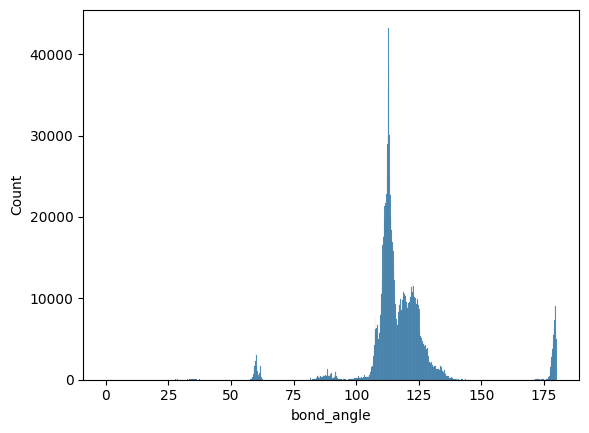

In [36]:
sns.histplot(train_extend[train_extend.bond_angle!=-1].bond_angle)

<Axes: xlabel='dihedral_angle', ylabel='Count'>

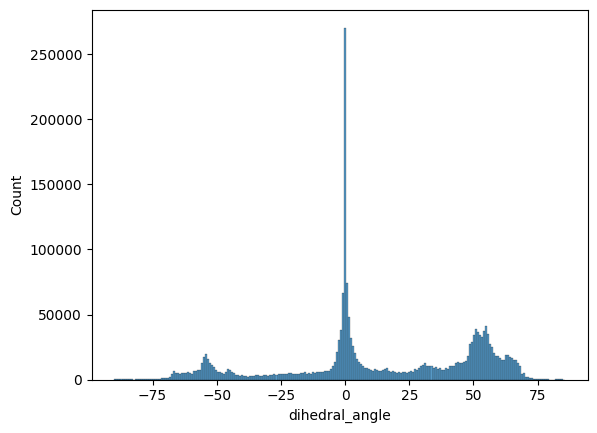

In [37]:
sns.histplot(train_extend[train_extend.dihedral_angle!=-1].dihedral_angle)

In [39]:
train_extend['is_linear'] = train_extend.dihedral_angle.map(lambda x: 1 if x == np.nan else 0)
train_extend['dihedral_angle'] = train_extend.dihedral_angle.map(lambda x: -2 if x == np.nan else x)

test_extend['is_linear'] = test_extend.dihedral_angle.map(lambda x: 1 if x == np.nan else 0)
test_extend['dihedral_angle'] = test_extend.dihedral_angle.map(lambda x: -2 if x == np.nan else x)


In [40]:
atom_types = structures.groupby(['molecule_name', 'atom'], sort=False).size().unstack('atom').fillna(0)
atom_types = atom_types.rename(columns={'C': 'num_C', 'H': 'num_H', 'N': 'num_N', 'O': 'num_O', 'F': 'num_F'})
atom_types.columns.name = None
atom_types.index.name = None
atom_types = atom_types.astype('int8')

In [41]:
atom_types.head()

,num_C,num_H,num_N,num_O,num_F
dsgdb9nsd_000001,1,4,0,0,0
dsgdb9nsd_000002,0,3,1,0,0
dsgdb9nsd_000003,0,2,0,1,0
dsgdb9nsd_000004,2,2,0,0,0
dsgdb9nsd_000005,1,1,1,0,0


In [52]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [51]:
n_atoms = pd.DataFrame(structures.groupby('molecule_name', sort=False).size(), columns=['total_atoms'])
centers = structures.drop(['atom_index', 'atom'], axis=1).groupby('molecule_name', sort=False).mean()
centers = centers.rename(columns={'x': 'center_x', 'y': 'center_y', 'z': 'center_z'})
centers.columns.name = None
centers.index.name = None

In [53]:
centers.head()

,center_x,center_y,center_z
dsgdb9nsd_000001,-0.012689,1.085797,0.008001
dsgdb9nsd_000002,0.093086,0.934733,-0.192278
dsgdb9nsd_000003,0.300732,0.766301,0.003276
dsgdb9nsd_000004,0.000000,0.000000,1.000000
dsgdb9nsd_000005,-0.012939,1.104085,0.008119


In [54]:
structures = pd.merge(structures, centers, how='left', left_on='molecule_name', right_index=True)

In [57]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,center_x,center_y,center_z,dx,dy,dz
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,-0.000009,0.000008,-4.582000e-07
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,-0.012689,1.085797,0.008001,0.014840,-1.091828,-6.025334e-03
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001,1.024420,0.377955,-7.724879e-03
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001,-0.528126,0.361730,-8.846452e-01
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001,-0.511125,0.352136,8.983958e-01


In [55]:
axis = ['x', 'y', 'z']
for ax in axis:
    structures[f'd{ax}'] = structures[ax] - structures[f'center_{ax}']

structures = structures.assign(center_dist=lambda x: np.sqrt(x.dx**2 + x.dy**2 + x.dz**2))

In [59]:
gb = structures[['molecule_name', 'center_dist']].groupby('molecule_name', sort=False)

# center of mass
min_centers = gb.min().rename(columns={'center_dist': 'min_center'})
min_centers.columns.name = None
min_centers.index.name = None

mean_centers = gb.mean().rename(columns={'center_dist': 'mean_center'})
mean_centers.columns.name = None
mean_centers.index.name = None

max_centers = gb.max().rename(columns={'center_dist': 'max_center'})
max_centers.columns.name = None
max_centers.index.name = None

structures.drop(['center_x', 'center_y', 'center_z', 'dx', 'dy', 'dz'], axis=1, inplace=True)


In [60]:
def merge_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how='left',
                  left_on=['molecule_name', f'atom_index_{atom_idx}'],
                  right_on=['molecule_name', 'atom_index'])
    df.drop(['atom_index', 'atom', 'x', 'y', 'z'], axis=1, inplace=True)
    df.rename(columns={'center_dist': f'center_dist_{atom_idx}'}, inplace=True)
    return df

train_extend = merge_atom_info(train_extend, 0)
train_extend = merge_atom_info(train_extend, 1)

test_extend = merge_atom_info(test_extend, 0)
test_extend = merge_atom_info(test_extend, 1)

In [63]:
# assembling molecule properties
properties = atom_types.join([n_atoms, min_centers, mean_centers, max_centers])
properties.head()

,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center
dsgdb9nsd_000001,1,4,0,0,0,5,0.000012,0.873562,1.091954
dsgdb9nsd_000002,0,3,1,0,0,4,0.301261,0.780244,0.939962
dsgdb9nsd_000003,0,2,0,1,0,3,0.396141,0.653496,0.782173
dsgdb9nsd_000004,2,2,0,0,0,4,0.599539,1.130589,1.661639
dsgdb9nsd_000005,1,1,1,0,0,3,0.028383,0.748910,1.123365


In [65]:
train_extend = pd.merge(train_extend, properties, how='left', left_on='molecule_name', right_index = True)
test_extend = pd.merge(test_extend, properties, how='left', left_on='molecule_name', right_index = True)

In [66]:
train_extend.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,...,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,C,4,1.091946,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,H,4,1.091946,...,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,H,4,1.091946,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,H,4,1.091946,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,C,4,1.091946,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954


In [67]:
train_extend.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'type_bond', 'target_atom', 'n_bonds',
       'min_d', 'mean_d', 'max_d', 'space_dist', 'bond_dist', 'bond_1',
       'bond_2', 'bond_3', 'atom_0_pc', 'target_atom_pc', 'atom_0_fc',
       'target_atom_fc', 'atom_0_val', 'target_atom_val', 'atom_0_sm',
       'target_atom_sm', 'atom_0_symbol', 'atom_2_symbol', 'atom_3_symbol',
       'target_atom_symbol', 'atom_0_hyb', 'atom_2_hyb', 'atom_3_hyb',
       'target_atom_hyb', 'path_count', 'bond_angle', 'dihedral_angle',
       'atom_0_min', 'atom_0_mean', 'atom_0_max', 'atom_0_Cmin',
       'atom_0_Cmean', 'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean',
       'atom_0_Omax', 'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax',
       'atom_0_Fmin', 'atom_0_Fmean', 'atom_0_Fmax', 'target_atom_min',
       'target_atom_mean', 'target_atom_max', 'target_atom_Cmin',
       'target_atom_Cmean', 'target_atom_Cmax', 'target_atom_Omin',
       'target_

In [ ]:
spin = namedtuple('spin', ['mu', 'spin', 'NMR'])
atomic_spins = {
    'H': spin(2.79284734, 0.5, 1),
    'C': spin(0.7024118, 0.5, 0.016),
    'O': spin(-1.89379,2.5,0.037),
    'N': spin(0.40376100, 1, 0.001),
    'F': spin(2.628868, 0.5, 0.83)
}

In [68]:
mulliken = pd.read_csv('mulliken_charges.csv')
test_mulliken = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/mulliken_charges_test_set.csv')

In [69]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
train_extend = train_extend.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
train_extend = train_extend.merge(mulliken, on=['molecule_name', 'atom_index_1'])

In [70]:
train_extend.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,...,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,H,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [71]:
test_mulliken = test_mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
test_extend = test_extend.merge(test_mulliken, on=['molecule_name', 'atom_index_0'])

test_mulliken = test_mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
test_extend = test_extend.merge(test_mulliken, on=['molecule_name', 'atom_index_1'])

In [72]:
test_extend.head()

,id,molecule_name,atom_index_0,atom_index_1,type,type_bond,target_atom,n_bonds,min_d,mean_d,...,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,4659076,dsgdb9nsd_000004,2,0,2JHC,2,C,3,1.062099,1.861485,...,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
1,4659079,dsgdb9nsd_000004,3,0,1JHC,1,C,3,1.062099,1.861485,...,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
2,4659077,dsgdb9nsd_000004,2,1,1JHC,1,C,3,1.062099,1.861485,...,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
3,4659080,dsgdb9nsd_000004,3,1,2JHC,2,C,3,1.062099,1.861485,...,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
4,4659078,dsgdb9nsd_000004,2,3,3JHH,3,H,3,1.062099,1.861485,...,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,0.175373


In [74]:
train_extend.shape

(4659076, 80)

In [76]:
test_extend.shape

(879177, 79)

In [77]:
train_extend.to_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv', index=False)
test_extend.to_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv', index=False)